<a href="https://colab.research.google.com/github/Subho95/Next_Word_Predictor/blob/master/LSTM_wordpredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Build Next word predictor using LSTM

In [ ]:
########### import all libraries
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive/')
%tensorflow_version 1.x
import tensorflow as tf
%matplotlib inline
import pickle
import numpy as np
from os import listdir
from os.path import isfile, join
import os
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

## Create a function that will extract the data from the dataset
Next, we download the training data. The popular book “Alice’s Adventures in Wonderland” written by Lewis Caroll has been used as training dataset for this project. The e-book can be downloaded from http://www.gutenberg.org/files/11/11-0.txt in Plain Text UTF-8 format. The downloaded book has been stored in the root directory with the name ‘wonderland.txt’. We open this book using the open command and convert all characters into lowercase (so as to reduce the number of characters in the vocabulary, making it easier to learn for the model.)

In [ ]:
############### Download CIFAR-10 data and save it to google drive
import requests  
file_url = "http://www.gutenberg.org/files/11/11-0.txt"
    
r = requests.get(file_url, stream = True)  
  
with open("/content/drive/My Drive/DeepNN_HandsOn/Alice_in_won.txt", "wb") as file:  
    for block in r.iter_content(chunk_size = 1024): 
         if block:  
             file.write(block)

In [ ]:
############# Read file data
file = open("/content/drive/My Drive/DeepNN_HandsOn/Alice_in_won.txt", encoding = 'utf8')
raw_text = file.read()    #you need to read further characters as well
raw_text = raw_text.lower()

## Creating Vocabulary

Next, we store all the distinct characters occurring in the book in the chars variable. We also remove some of the rare characters (stored in bad-chars) from the book. The final vocabulary of the book is printed at the end of code segment.

In [ ]:
chars = sorted(list(set(raw_text)))
print(chars)
bad_chars = ['#', '*', '@', '_', '\ufeff']
for i in range(len(bad_chars)):
    raw_text = raw_text.replace(bad_chars[i],"")

chars = sorted(list(set(raw_text)))
print(chars)

['\n', ' ', '!', '#', '$', '%', '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', '@', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '‘', '’', '“', '”', '\ufeff']
['\n', ' ', '!', '$', '%', '(', ')', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', '[', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '‘', '’', '“', '”']


# Summarize entire text

In [ ]:
text_length = len(raw_text)
char_length = len(chars)
VOCABULARY = char_length
SEQ_LENGTH =100
print("Text length = " + str(text_length))
print("No. of characters = " + str(char_length))

Text length = 163721
No. of characters = 56


# Preprocess data

Now, we need to modify the dataset representation to bring it in the form the model will need. So, we create an input window of 100 characters (SEQ_LENGTH = 100) and shift the window one character at a time until we reach the end of the book. An encoding is used, so as to map each of the characters into it’s corresponding location in the vocabulary. Each time the input window contains a new sequence, it is converted into integers, using this encoding and appended to the input list of the dataset, input_strings. For all such input windows, the character just following the sequence is appended to the output list output_strings

In [ ]:

char_to_int = dict((c, i) for i, c in enumerate(chars))
input_strings = []
output_strings = []

for i in range(len(raw_text) - SEQ_LENGTH):
    X_text = raw_text[i: i + SEQ_LENGTH]
    X = [char_to_int[char] for char in X_text]
    input_strings.append(X)    
    Y = raw_text[i + SEQ_LENGTH]
    output_strings.append(char_to_int[Y])
# The input_strings and output_strings lists are converted into a numpy array of required dimensions, so that they can be fed to the model for the training.
length = len(input_strings)
input_strings = np.array(input_strings)
input_strings = np.reshape(input_strings, (input_strings.shape[0], input_strings.shape[1], 1))
input_strings = input_strings/float(VOCABULARY)

output_strings = np.array(output_strings)
output_strings = np_utils.to_categorical(output_strings)
print(input_strings.shape)
print(output_strings.shape)

(163621, 100, 1)
(163621, 56)


# Design the Model

We define the model now. The model is given an input of 100 character sequences and it outputs the respective probabilities with which a character can succeed the input sequence. The model consists of 3 hidden layers. The first two hidden layers consist of 256 LSTM cells, and the second layer is fully connected to the third layer. The number of neurons in the third layer is same as the number of unique characters in the training set (the vocabulary of the training set). The neurons in the third layer, use softmax activation so as to convert their outputs into respective probabilities. The loss used is Categorical cross entropy and the optimizer used is Adam.

In [ ]:
def buildmodel(VOCABULARY):
    model = Sequential()
    model.add(LSTM(256, input_shape = (SEQ_LENGTH, 1), return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(256))
    model.add(Dropout(0.2))
    model.add(Dense(VOCABULARY, activation = 'softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')
    return model

## Running the model

You can try different layouts to improve the accuracy

In [ ]:
filepath="/content/drive/My Drive/DeepNN_HandsOn/LSTM_saved_models/weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
model = buildmodel(VOCABULARY)
history = model.fit(input_
strings
strings, output_strings, epochs = 5, batch_size = 128, callbacks = callbacks_list)

Epoch 1/5
163621/163621 [==============================] - 359s 2ms/step - loss: 2.9064

Epoch 00001: loss improved from inf to 2.90637, saving model to /content/drive/My Drive/DeepNN_HandsOn/LSTM_saved_models/weights-improvement-01-2.9064.hdf5
Epoch 2/5
163621/163621 [==============================] - 358s 2ms/step - loss: 2.5972

Epoch 00002: loss improved from 2.90637 to 2.59722, saving model to /content/drive/My Drive/DeepNN_HandsOn/LSTM_saved_models/weights-improvement-02-2.5972.hdf5
Epoch 3/5
 66944/163621 [===========>..................] - ETA: 3:34 - loss: 2.4552

## Next word Prediction

The original model has been defined in a manner to take in 100 character inputs. So when the user initially starts typing the words, the total length of input string will be less than 100 characters. To solve this issue, the input has been padded with series of spaces in the beginning in order to make the total length of 100 characters. As the total length exceeds 100 characters, only last 100 characters are taken into consideration as the LSTM nodes take care of remembering the context of the document from before.

Succeeding characters are predicted by the model until a space or full stop is encountered. The predicted characters are joined to form the next word, predicted by the mode

In [ ]:
####### load weights
model = buildmodel(VOCABULARY)
model.load_weights("/content/drive/My Drive/DeepNN_HandsOn/LSTM_saved_models/weights-improvement-50-1.3195.hdf5")




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.










In [ ]:
import ipywidgets as widgets
original_text = []
predicted_text = []

text = widgets.Text()
display(text)

def handle_submit(sender):
    global predicted_text
    global original_text
    
    inp = list(text.value)
    
    last_word = inp[len(original_text):]
    inp = inp[:len(original_text)]    
    original_text = text.value    
    last_word.append(' ')
    
    inp_text = [char_to_int[c] for c in inp]
    last_word = [char_to_int[c] for c in last_word]
    
    if len(inp_text) > 100:
        inp_text = inp_text[len(inp_text)-100: ]
    if len(inp_text) < 100:
        pad = []
        space = char_to_int[' ']
        pad = [space for i in range(100-len(inp_text))]
        inp_text = pad + inp_text
    
    while len(last_word)>0:
        X = np.reshape(inp_text, (1, SEQ_LENGTH, 1))
        next_char = model.predict(X/float(VOCABULARY))
        inp_text.append(last_word[0])
        inp_text = inp_text[1:]
        last_word.pop(0)
    
    next_word = []
    next_char = ':'
    while next_char != ' ':
        X = np.reshape(inp_text, (1, SEQ_LENGTH, 1))
        next_char = model.predict(X/float(VOCABULARY))
        index = np.argmax(next_char)        
        next_word.append(chars[index])
        inp_text.append(index)
        inp_text = inp_text[1:]
        next_char = chars[index]
    
    predicted_text = predicted_text + [''.join(next_word)]
    print(" " + ''.join(next_word), end='|')
    
text.on_submit(handle_submit)

Text(value='')

 the | tp | fand | degan | and |

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


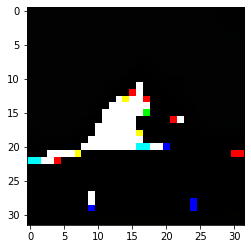

In [ ]:
#view images
gen = datagen.flow(x_train, y_train, batch_size=64)
x,y = gen.next()
image = x[0].astype('uint')
plt.imshow(image)

## Compiling the model

In [ ]:
# Compile the model
batch_size = 64

opt_rms = keras.optimizers.rmsprop(lr=0.001, decay=1e-6)
model.compile(loss='categorical_crossentropy', 
              optimizer=opt_rms, 
              metrics=['accuracy'])

## Training the algorithm
I would suggest more than 100 epochs

In [ ]:
epochs = 20
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

Epoch 1/20
781/781 [==============================] - 24s 31ms/step - loss: 1.5651 - acc: 0.4483 - val_loss: 1.6769 - val_acc: 0.4055
Epoch 2/20
781/781 [==============================] - 24s 30ms/step - loss: 1.5130 - acc: 0.4628 - val_loss: 1.3075 - val_acc: 0.5514
Epoch 3/20
781/781 [==============================] - 23s 30ms/step - loss: 1.4965 - acc: 0.4680 - val_loss: 1.7274 - val_acc: 0.4102
Epoch 4/20
781/781 [==============================] - 24s 30ms/step - loss: 1.4838 - acc: 0.4785 - val_loss: 1.2818 - val_acc: 0.5297
Epoch 5/20
781/781 [==============================] - 24s 30ms/step - loss: 1.4747 - acc: 0.4743 - val_loss: 1.3360 - val_acc: 0.5152
Epoch 6/20
781/781 [==============================] - 24s 30ms/step - loss: 1.4550 - acc: 0.4838 - val_loss: 1.2076 - val_acc: 0.5693
Epoch 7/20
781/781 [==============================] - 24s 30ms/step - loss: 1.4521 - acc: 0.4856 - val_loss: 1.3794 - val_acc: 0.5148
Epoch 8/20
781/781 [==============================] - 23s 30ms

In [ ]:
out= model.predict(x_train[0:4])
out[3]

NameError: ignored